In [24]:
from astropy.io import fits
from astropy.io import ascii as asc
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import pandas as pd
import os
import json
import copy
import shutil as sh
import time
import regex as re

Just some predefined and useful functions to keep handy

In [52]:
def getimg_name(ogimg_path):
    file_image = os.path.basename(ogimg_path)
    image_stripped_name = os.path.splitext(file_image)[0]
    #print(image_stripped_name)
    return str(image_stripped_name)

def rmr_careful(dir):
    if (os.path.basename(dir) == 'Random_Storage') or (os.path.basename(dir) == 'Random_Storage'):
        print('Error, check path')
    else:
        print('Removing the folder:', dir)
        sh.rmtree(dir)

def rm_copy(config_folder, out_folder):
        if os.path.exists(out_folder):
            if (os.path.basename(out_folder) == 'Rad') or (os.path.basename(out_folder) == 'Desktop'):
                print('Error, check path \n\n\n\n\n\n\n\n')
            else:
                sh.rmtree(out_folder)
                print('Deleted old', out_folder)
                sh.copytree(config_folder, out_folder)
                print('Inserted config folder', config_folder) # Inserts the configuration and param files for Source Extractor into
                                                           # a Folder in which it can be accessed 
        elif not os.path.exists(out_folder): #makes the directory if it doesn't exist
            sh.copytree(config_folder, out_folder)
            print('Inserted config folder:', config_folder,  'made new out folder')

def get_SEcat(chimg_dir, catalog_name):
    ogcwd = os.getcwd()
    os.chdir(chimg_dir)
    
    SE_catalog = asc.read(catalog_name) #'output_cold_Image2view_1_ag5_21.cat'
    df_cat = pd.DataFrame()

    for column in SE_catalog.columns:
        df_cat[column] = np.array(SE_catalog[column])
    
    df_cat['Surface_Brightness'] = df_cat['MAG_AUTO'] + 2.5 * (np.log(2 * np.pi * (   (df_cat['FLUX_RADIUS'] * 0.06)**2)))/(np.log(10))
    df_cat = df_cat[['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'FWHM_IMAGE', 'FLUX_RADIUS', 'MAG_AUTO', 'Surface_Brightness', 'FLAGS']]
    df_flags = df_cat['FLAGS'].unique()
    print(df_flags)
    
    os.chdir(ogcwd)

    return df_cat

def clean_round(df):
    for column in df.columns:
        df[column] = round(df[column], 2)

def add_weight(complete_img_path):
    split_name = os.path.splitext(complete_img_path)
    weight_img_path = split_name[0] + '_weight' + split_name[1]
    return weight_img_path



All the important methods

In [45]:
def extract_params(paramfile):
        '''
    This function extracts the parameters the user has set for
    the program from a text file.

    ------

    Parameters:

    paramfile (string): The path to the text file containing the 
    user's preferred parameters.

    ------

    Outputs:

    dir (string): the path to the directory all of the program's 
    output will be sent to.

    image (string): the path to the image to be used as a 
    base for inserting fake galaxies.

    sexparams (string): the path to the Source Extractor
    parameter file to be used.
    '''
        def get_sex_params(config_folder):# This function extracts the
            n_param_file = 0              #   config file to run the SExtractor
            sex_params = None
            for file in os.listdir(config_folder):
                if file.endswith('.sex'):
                    # print(file)
                    sex_params = os.path.join(config_folder, file)
                    n_param_file = n_param_file + 1
            if n_param_file == 0:
                print('param file not found')
            return sex_params
        
        print(paramfile)
        file = open(paramfile)
        params = []
        lines = file.readlines()
        file.close()

        for n_line in range(2, len(lines)):
            line_list = lines[n_line].strip().split(': ')
            try:
                req_num = int(line_list[1])
                params.append(req_num)
                #print('stuff', type(req_num))
            except:
                params.append(line_list[1])
                continue
        # print(params)

        print('Params:', params)

        dir = params[0]
        view_img = params[1]
        config_folder = params[2]
        sexparam_file = get_sex_params(params[2])

        weight_img = add_weight(view_img)

        
        
        #print(*(param for param in params), sep ='\n\n')
        return dir, sexparam_file, config_folder, view_img, weight_img

def create_SEoutput_img_folder(output_dir, img_pair, config_folder):
    img_path = img_pair[0]
    weight_img = img_pair[1]
    img_name = getimg_name(img_path)
    img_outfolder_name = 'output_' + img_name
    img_output_dir = os.path.join(output_dir, img_outfolder_name)


    if not os.path.exists(output_dir):
        print(output_dir)
        os.makedirs(output_dir)

    if not os.path.exists(img_output_dir):
        os.mkdir(img_output_dir)
        sh.copy(img_path, img_output_dir)
        sh.copy(weight_img, img_output_dir)
        sh.copytree(config_folder, img_output_dir, dirs_exist_ok=True)

        print('Didnt exist before, but now it does')
    elif os.path.exists(img_output_dir):
        rmr_careful(img_output_dir)
        print('Deleted old', img_output_dir)

        os.mkdir(img_output_dir)
        sh.copy(img_path, img_output_dir)
        sh.copy(weight_img, img_output_dir)
        sh.copytree(config_folder, img_output_dir, dirs_exist_ok=True)
        
        print(f'Inserted new config folder, {config_folder}, Inserted new image: {img_outfolder_name}') 
    print(img_output_dir,'\n', os.listdir(img_output_dir))
    return img_output_dir

def run_sextr(img_output_dir, sexparams):
    '''
    This function runs the images with inserted galaxies through Source
    Extractor.

    -----

    Parameters:

    dir (string): the path to the directory that image to be used is
    located in.

    -----

    Outputs:

    None
    '''
    cwd = os.getcwd()
    os.chdir(img_output_dir)

    for img in os.listdir(img_output_dir): #runs through every file in the directory
        if img.endswith('.fits') & (img.find('weight') < 0): #and checks if it's a .fits file
            print(img) #tells the user which images is being run 
            imgname = os.path.splitext(os.path.basename(img))[0] #removes the .fits from the filename
            catname = img_output_dir + '/output_test' + imgname + '.cat' #the name for the SEx catalog output file
            checkname = img_output_dir + '/check_' + imgname + '.fits' #the name for the SEx check image

            #Assembling the command to be passed to Source Extractor
            basecmd = 'sex ' + img_output_dir+'/'+img + ' -c '+sexparams
            catcmd = '-catalog_name ' + catname 
            checkcmd = '-checkimage_name ' + checkname
            sexcmd = basecmd + ' ' + catcmd + ' ' + checkcmd
            
            print(sexcmd)
            os.system(sexcmd)
    os.chdir(cwd)
    return catname

def SEcat_filter(df_SEcat: pd.DataFrame, column = 'FLUX_RADIUS', threshold_multiplier = 2):
    df_best = df_SEcat[df_SEcat['FLUX_RADIUS'] > 18].copy()
    # if column == 'Surface_Brightness':
    #     df_best = df_SEcat[(df_SEcat[column] < 27.5)  & (df_SEcat[column] > 24.5)].copy()
    df_best = df_best.sort_values(by= [column], ascending = False)
    # df_best = df_best.head(5)
    df_best.reset_index(inplace = True)
    df_best.drop(columns = ['index'], inplace = True)

    return df_best

def find_compare_coordinates(coordinates, df_SEcat: pd.DataFrame):
    del_x = (df_SEcat['X_IMAGE'] - coordinates['X'])
    del_y = (df_SEcat['Y_IMAGE'] - coordinates['Y'])
    df_SEcat['Dist'] = np.sqrt( del_x**2 + del_y**2 )
    df_SEcat.sort_values(by = ['Dist'], inplace= True)

    return df_SEcat


def plot_img(img_path):
    img_name = getimg_name(img_path)
    read_img = fits.open(img_path)
    img_data = read_img[0].data
    log_img = np.log10(img_data)
    #print('read img data')

    fig, ax = plt.subplots()

    plt.figure(figsize=(10, 10))
    if img_path.find('check') >= 0:
        img_plot = ax.imshow(img_data, cmap='gray', origin='lower', vmin= -1, vmax=2)
    else:
        img_plot = ax.imshow(log_img, cmap='gray', origin='lower', vmin= -2, vmax=0)
    ax.set_title(img_name)

    return img_plot, fig, ax

def plot_points(ax, df, columns =['X_IMAGE', 'Y_IMAGE'], color = 'red', c_rad = 30):
    colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "pink", "pink", "pink"]
    for index in df.index: #len(df_candidates.index)
        x_orange = df.loc[index, columns[0]]
        y_orange = df.loc[index, columns[1]]
        
        #Settings for coloured purple dots.
        #orange_circle = Circle((x_orange, y_orange), radius=3, edgecolor='purple', facecolor='purple')
        circle = Circle((x_orange, y_orange), radius= c_rad, edgecolor=colors[index], facecolor= 'none')
        
        ax.add_patch(circle)
        ax.text(x= x_orange, y= y_orange, s= int(index), fontsize = 12, color = colors[index])

def run_finder(paramfile, coordinates = None):
    out_dir, sex_param_file, sex_config_folder, view_img, weight_img = extract_params(paramfile)
    pair_images = [view_img, weight_img]

    img_output_dir = create_SEoutput_img_folder(out_dir, pair_images, sex_config_folder)

    catalog_name = run_sextr(img_output_dir, sex_param_file)

    time.sleep(2)

    df_SE = get_SEcat(img_output_dir, catalog_name)

    df_filtered = SEcat_filter(df_SE, column= 'FLUX_RADIUS')

    # print(df_filtered)
    if coordinates is not None:
        df_with_distances = find_compare_coordinates(coordinates, df_filtered)
    else:
        df_with_distances =  df_filtered
    clean_round(df_with_distances)
    print(df_with_distances.head(10))

    df_plots = df_with_distances.head(10)

    img_plot, fig, ax = plot_img(view_img)
    
    plot_points(ax, df_plots)



In [29]:
def get_filedir(complete_path):
    all_dirs = complete_path.split('/')[1:-1]
    dirof_file = '/' + '/'.join(all_dirs)
    return dirof_file

def lines_lister(file_path):
    with open(file_path) as opened_file:
        lines_in_file = opened_file.readlines()
    return lines_in_file



def find_param(paramfile, param = 'DIR'):
    list_lines = lines_lister(paramfile)

    for line_index in range(len(list_lines)):
        line = list_lines[line_index]

        if (line.startswith(param)) & (line.find('#') > 0):
            element_list = line.split('#')[0].split(': ')
            output_dir = element_list[1]

        elif line.startswith(param):
                element_list = line.strip().split(': ')
                output_dir = element_list[1]
    
    return output_dir

def create_space(name_str, n_spaces, end_str):
    for i in range(n_spaces):
        name_str = name_str + ' '
    
    final_str = name_str + str(end_str)

    return final_str

def value_change(list_lines, str_to_change, step_size = 0.1):
    new_lines = list_lines.copy()


    for line_index in range(len(list_lines)):
        line = list_lines[line_index]
        if (line.startswith(str_to_change)) & (line.find('#') > 0):
            
            element_list = line.split('#')[0].split()

            # print('Hello', element_list[1])
            
            element_list[1] = round(float(element_list[1]) + step_size, 3)

            new_value = element_list[1]

            n_spaces = 17 - len(element_list[0])
            space_str = create_space(element_list[0], n_spaces, element_list[1])

            final_str = space_str + ' #' + line.split('#')[1]
            new_lines[line_index] = final_str

        elif line.startswith(str_to_change):

            element_list = line.split()

            element_list[1] = round(float(element_list[1]) + step_size, 3)

            new_value = element_list[1]

            n_spaces = 17 - len(element_list[0])

            final_str = create_space(element_list[0], n_spaces, element_list[1])
            
            new_lines[line_index] = final_str
    
    print('NEW VALUE :', new_value)
        
    return new_lines, new_value

def addreplace_param(file_lines, param_to_replace, new_str, add_str = False, split_condition = ': '):
    new_lines = file_lines.copy()
    indexer = 0
    for line_index in range(len(file_lines)):
        line = file_lines[line_index]
        if len(line) == 0:
            continue
        
        if (line.startswith(param_to_replace)) & (line.find('#') > 0):
            line_elements = line.split('#')[0].split(split_condition)
            old_str = line_elements[1].strip()
            if add_str == True:
                final_str = line_elements[0] + split_condition + old_str + str(new_str) + ' #' + line.split('#')[1]
            elif add_str == False:
                final_str = line_elements[0] + split_condition + str(new_str) + ' #' + line.split('#')[1]

            new_lines[line_index] = final_str
            indexer += 1
            
        elif line.startswith(param_to_replace):
            line_elements = line.split(split_condition)
            old_str = line_elements[1].strip()
            if add_str == True:
                final_str = line_elements[0] + split_condition + old_str + str(new_str) + '\n'
            elif add_str == False:
                final_str = line_elements[0] + split_condition + str(new_str) + '\n'
            
            new_lines[line_index] = final_str
            indexer += 1  

    if indexer <= 0:
        print(f'replacing the param with {param_to_replace} has not worked')
    
    return new_lines

def value_reset(list_lines, str_to_change, orig_num):
    new_lines = list_lines.copy()
    for line_index in range(len(list_lines)):
        line = list_lines[line_index]
        if (line.startswith(str_to_change)) & (line.find('#') > 0):
            
            element_list = line.split('#')[0].split()
            
            element_list[1] = orig_num

            n_spaces = 17 - len(element_list[0])
            space_str = create_space(element_list[0], n_spaces, element_list[1])

            final_str = space_str + ' #' + line.split('#')[1]
            new_lines[line_index] = final_str

        elif line.startswith(str_to_change):

            element_list = line.split()

            element_list[1] = orig_num
            n_spaces = 17 - len(element_list[0])

            final_str = create_space(element_list[0], n_spaces, element_list[1])
            
            new_lines[line_index] = final_str
        
    return new_lines

def write_file(new_file_dir, updated_line_list: list):
    with open(new_file_dir, 'w') as overwritten:
        overwritten.writelines(updated_line_list)


def mutlti_image_run(main_paramfile, imgs_dir, outer_dir):

    param_lines = lines_lister(main_paramfile) # lists the lines in the paramfile

    sex_param_file = find_param(main_paramfile, 'SEX_CONFIG_FOLDER') # Find the config folder in which SE's required files are

    for file in os.listdir(sex_param_file):
        if file.endswith('.sex'):
            complete_sex_path = os.path.join(sex_param_file, file) # Creates a ready made path for SE's .sex file.
            sex_lines = lines_lister(complete_sex_path) # Gets the lines from the .sex file
            SEx_file = complete_sex_path
        else:
            continue
    
    if len(SEx_file) > 0: # Diagnostic Tool
        print('Found SEx file in config folder')
    else:
        print('Cannot continue, no SEx param file')
    
    imgs_list = []
    for img_file in os.listdir(imgs_dir): # This creates a list of the image names of the images that will be used.
        if (img_file.find('weight') < 0) & img_file.endswith('.fits'): # Avoids the uncessary weight files and gets the main image files
            imgs_list.append(img_file)
    
    print(imgs_list)
    
    imgs_indexer = 0 # To keep track of where the code is when its running
    for img in imgs_list:
    
        complete_img_path = os.path.join(imgs_dir, img) # Creates a complete image path that will be used ahead
        new_lines = addreplace_param(param_lines, param_to_replace= 'IMAGE', new_str= complete_img_path) # For each iteration, the paramfile need's the image path that it uses to be updated
        # print(new_lines[3])

        outdir_setter = outer_dir  # Creates the output directory's name for use + '/' + os.path.splitext(img)[0] + '_results'
        new_lines = addreplace_param(new_lines, param_to_replace= 'OUTPUT_DIR', new_str= outdir_setter) # Writes the new output directory to the parameter file

        print(main_paramfile)
        txt_name = os.path.basename(main_paramfile)
        print(txt_name)
        pen_paramfile_dir = get_filedir(main_paramfile)
        print("Just before:", pen_paramfile_dir)
        splitfile = os.path.splitext(txt_name)[0] # Seperates the file path from its extension
        print("Split-file name:", splitfile)
        
        cut_name = splitfile.split('_')[0] # Removes the _topfile
        print("cut file name:", cut_name)

        new_paramfile_name = pen_paramfile_dir + '/' + cut_name  + '_ready.txt'  # Adds the _ready.txt

        print("This is the paramfile's name:", new_paramfile_name)

        print(sex_param_file)

        write_file(new_paramfile_name, new_lines) #Writes the new lines to the file that will used to find the UDGs

        new_weight_path = add_weight(complete_img_path) # This creates the weight image's file name for the current image

        new_sex_lines = addreplace_param(sex_lines, param_to_replace= 'WEIGHT_IMAGE', new_str= new_weight_path, split_condition= '   ') # Replaces it in the SE .sex file

        write_file(SEx_file, new_sex_lines) # Writes the new lines to the new SE .sex file

        run_finder(new_paramfile_name) # Runs the function that runs SE, creates an output folder in which all the data is kept

        print('\n\n')

        imgs_indexer = imgs_indexer + 1
        print(f'DONE WITH IMG: {img}, {imgs_indexer}/{len(imgs_list)}')

    print('COMPLETELY COMPLETELY DONE')
    write_file(SEx_file, sex_lines)

parameter_file = '/Users/mokshahuja/Desktop/14_RD_pipeline/UDG_topfile.txt'
all_images_dir = '/Users/mokshahuja/Desktop/ASTRES/F606_Test241007'
outer_dir = '/Volumes/Random_Storage/ProtectionLayer/F606_Results_241007'


Found SEx file in config folder
['Visit566.fits', 'Visit112.fits']
/Users/mokshahuja/Desktop/14_RD_pipeline/UDG_topfile.txt
UDG_topfile.txt
Just before: /Users/mokshahuja/Desktop/14_RD_pipeline
Split-file name: UDG_topfile
cut file name: UDG
This is the paramfile's name: /Users/mokshahuja/Desktop/14_RD_pipeline/UDG_ready.txt
/Users/mokshahuja/Desktop/14_RD_pipeline/config_pipe
/Users/mokshahuja/Desktop/14_RD_pipeline/UDG_ready.txt
Params: ['/Volumes/Random_Storage/ProtectionLayer/F606_Results_241007', '/Users/mokshahuja/Desktop/ASTRES/F606_Test241007/Visit566.fits', '/Users/mokshahuja/Desktop/14_RD_pipeline/config_pipe']
Removing the folder: /Volumes/Random_Storage/ProtectionLayer/F606_Results_241007/output_Visit566
Deleted old /Volumes/Random_Storage/ProtectionLayer/F606_Results_241007/output_Visit566
Inserted new config folder, /Users/mokshahuja/Desktop/14_RD_pipeline/config_pipe, Inserted new image: output_Visit566
/Volumes/Random_Storage/ProtectionLayer/F606_Results_241007/output_V

> 
----- SExtractor 2.28.0 started on 2024-10-11 at 12:24:59 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for Visit566.fits
----- Measuring from: Visit566.fits [0/2]
      "Unnamed" / no ext. header / 3510x3535 / 32 bits (floats)
> Looking for Visit566_weight.fits
----- Weighting from: Visit566_weight.fits
      "Unnamed" / no ext. header / 3510x3535 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 256

[153]
Empty DataFrame
Columns: [NUMBER, X_IMAGE, Y_IMAGE, FWHM_IMAGE, FLUX_RADIUS, MAG_AUTO, Surface_Brightness, FLAGS]
Index: []



DONE WITH IMG: Visit566.fits, 1/2
/Users/mokshahuja/Desktop/14_RD_pipeline/UDG_topfile.txt
UDG_topfile.txt
Just before: /Users/mokshahuja/Desktop/14_RD_pipeline
Split-file name: UDG_topfile
cut file name: UDG
This is the paramfile's name: /Users/mokshahuja/Desktop/14_RD_pipeline/UDG_ready.txt
/Users/mokshahuja/Desktop/14_RD_pipeline/config_pipe
/Users/mokshahuja/Desktop/14_RD_pipeline/UDG_ready.txt
Params: ['/Volumes/Random_Storage/ProtectionLayer/F606_Results_241007', '/Users/mokshahuja/Desktop/ASTRES/F606_Test241007/Visit112.fits', '/Users/mokshahuja/Desktop/14_RD_pipeline/config_pipe']
Removing the folder: /Volumes/Random_Storage/ProtectionLayer/F606_Results_241007/output_Visit112
Deleted old /Volumes/Random_Storage/ProtectionLayer/F606_Results_241007/output_Visit112
Inserted new config folder, /Users/mokshahuja/Desktop/14_RD_pipeline/config_pipe, Inse

> 
----- SExtractor 2.28.0 started on 2024-10-11 at 12:25:02 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for Visit112.fits
----- Measuring from: Visit112.fits [0/2]
      "Unnamed" / no ext. header / 3529x3685 / 32 bits (floats)
> Looking for Visit112_weight.fits
----- Weighting from: Visit112_weight.fits
      "Unnamed" / no ext. header / 3529x3685 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 256

[ 2  0 17  1 16  3 25]
   NUMBER  X_IMAGE  Y_IMAGE  FWHM_IMAGE  FLUX_RADIUS  MAG_AUTO  \
0     600   188.92  1951.40       28.56       102.68     17.79   
1     749  3297.65  2167.27      554.24        87.84     17.39   
2      25  1327.22  3567.67       68.51        43.40     20.38   
3     625  2310.89  2016.12       25.94        38.93     23.84   
4       2   944.84   576.94      310.03        31.34     17.01   
5       5  1230.68    71.08       50.90        24.72     23.21   
6       1  1811.89  2125.37       18.34        23.08     14.73   
7     757  3463.62  2402.78       29.77        20.95     21.95   
8     533  3444.10  2466.24       34.19        20.40     22.01   
9     597  3484.66  2380.28       41.31        18.19     21.75   

   Surface_Brightness  FLAGS  
0               23.74     17  
1               23.00     17  
2               24.45     17  
3               27.67      1  
4               20.38      0  
5               26.06     17  
6               17.43      2  
7 

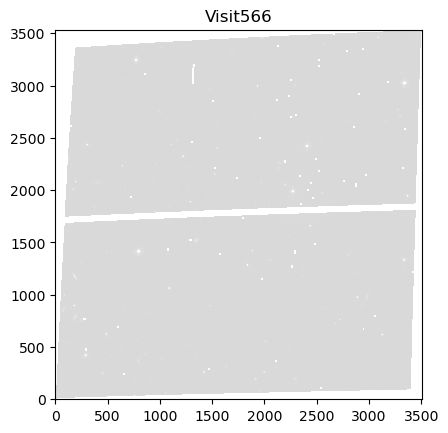

<Figure size 1000x1000 with 0 Axes>

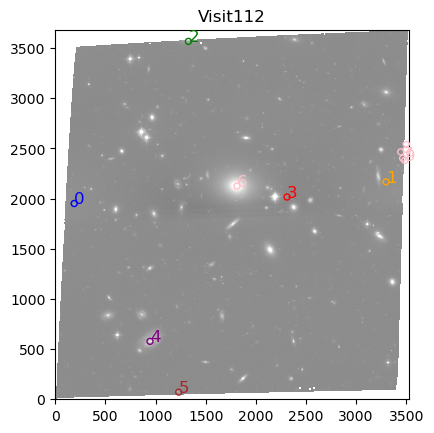

<Figure size 1000x1000 with 0 Axes>

In [53]:
mutlti_image_run(parameter_file, all_images_dir, outer_dir)

Define the variables

In [10]:
print('hello')

hello


In [8]:
DF44_paramfile = '/Users/mokshahuja/Desktop/14_RD_pipeline/UDG_topfile.txt'
DF44_loc = {'X': 1721, 'Y': 686}

Run the line below

In [9]:
run_finder(DF44_paramfile, DF44_loc)

/Users/mokshahuja/Desktop/14_RD_pipeline/UDG_topfile.txt
Params: ['/Volumes/Random_Storage/ProtectionLayer/F606_Results/', '/Users/mokshahuja/Desktop/ASTRES/F606_TestImages', '/Users/mokshahuja/Desktop/14_RD_pipeline/config_pipe']
Removing the folder: /Volumes/Random_Storage/ProtectionLayer/F606_Results/output_F606_TestImages
Deleted old /Volumes/Random_Storage/ProtectionLayer/F606_Results/output_F606_TestImages


IsADirectoryError: [Errno 21] Is a directory: '/Users/mokshahuja/Desktop/ASTRES/F606_TestImages'

In [ ]:
def mutlti_image_run(main_paramfile, imgs_dir, outer_dir, loopargs = [1, 3, 3], se_knob = 'DETECT_THRESH'):

    param_lines = lines_lister(main_paramfile)

    starting_val = loopargs[0]
    ending_val = loopargs[1]
    n_steps = loopargs[2]

    sex_param_file = find_param(main_paramfile, 'SEX PARAMETER FILE')

    for file in os.listdir(sex_param_file):
        if file.endswith('.sex'):
            complete_sex_path = os.path.join(sex_param_file, file)
            sex_lines = lines_lister(complete_sex_path)
            SEx_file = complete_sex_path
        else:
            continue
    
    if len(SEx_file) > 0:
        print('Found SEx file in config folder')
    else:
        print('Cannot continue, no SEx param file')
    
    imgs_list = []
    for img_file in os.listdir(imgs_dir):
        if (img_file.find('weight') < 0) & img_file.endswith('.fits'):
            imgs_list.append(img_file)
    
    print(imgs_list)
    
    imgs_indexer = 0
    for img in imgs_list:
        if img == '.DS_Store':
            imgs_indexer = imgs_indexer + 1
            continue
        elif img.find('weight') > 0:
            imgs_indexer = imgs_indexer + 1
            continue
        
        complete_img_path = os.path.join(imgs_dir, img)
        new_lines = addreplace_param(param_lines, param_to_replace= 'IMAGE', new_str= complete_img_path)